In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
data = pd.read_csv('../data/hbv_s_data.csv', index_col=0, parse_dates=True)

In [89]:
def simhyd_simulation(data, params):
    '''
    SIMHYD hydrological model (Chiew, 2009)
    Input:
    data - pandas dataframe with correspondent variables:
        'Temp' - daily temperature (Celsium degrees)
        'Prec' - daily precipitation (mm/day)
        'Evap' - potential evapotraspiration (mm/day)
    parameters:
        'INSC' - interception store capacity (mm)
            [0, 50]
        'COEFF'- maximum infiltration loss
            [0, 400]
        'SQ'   - infiltration loss exponent
            [0, 10]
        'SMSC' - soil moisture storage capacity
            [1, 1000]
        'SUB'  - constant of proportionality in interflow equation
            [0, 1]
        'CRAK' - constant of proportionality in groundwater recharge equation
            [0, 1]
        'K'    - baseflow linear recession parameter
            [0, 1]
        'etmul'- added parameter to convert maxT to PET
            [0.1, 3]
        Muskinghum routing parameters
        'DELAY'- runoff delay
            [0.1, 5]
        'X_m'  - transformation parameter
            [0.01, 0.5]
    '''
    ### read parameters ###
    INSC, COEFF, SQ, SMSC, SUB, CRAK, K, etmul, DELAY, X_m = params
    
    ### read the data ###
    #Temp = data['Temp']
    Prec = data['Prec']
    Evap = data['Evap'] * etmul
    
    ### states and parameters initialization ###
    # total runoff
    U    = np.zeros(len(Prec))
    # interception store
    IMAX = np.zeros(len(Prec)) 
    # interception amount
    INT  = np.zeros(len(Prec)) 
    # interception runoff
    INR  = np.zeros(len(Prec)) 
    # infiltration capacity
    RMO  = np.zeros(len(Prec)) 
    # direct runoff
    IRUN = np.zeros(len(Prec)) 
    # Soil evaporation
    ET   = np.zeros(len(Prec)) 
    # Saturation excess runoff and interflow
    SRUN = np.zeros(len(Prec)) 
    # Recharge
    REC  = np.zeros(len(Prec)) 
    # Infiltration into soil store
    SMF  = np.zeros(len(Prec)) 
    # potential evapotranspiration (PET - interception)
    POT  = np.zeros(len(Prec)) 
    # baseflow
    BAS  = np.zeros(len(Prec)) 
    # soil moisture storage
    SMS  = np.zeros(len(Prec)) 
    # ground water storage
    GW   = np.zeros(len(Prec))
    
    GWt1, GWt0 = 0, 0
    SMSt0 = 0.5
    SMSt1 = SMSt0 * SMSC
    
    for t in range(len(Prec)):
        # calculate interception store
        IMAX[t] = min(INSC, Evap[t])
        # then calculate interception
        INT[t] = min(IMAX[t], Prec[t])
        # calculate runoff after interception
        INR[t] = Prec[t] - INT[t]
        # calculate infiltration capacity
        RMO[t] = min(COEFF*np.exp(-SQ*SMSt1/SMSC), INR[t])
        # calculate direct runoff after loading to infiltration capacity
        IRUN[t] = INR[t] - RMO[t]
        # saturation excess runoff and interflow
        SRUN[t] = SUB * SMSt1 / SMSC * RMO[t]
        # calculate recharge
        REC[t] = CRAK * SMSt1 / SMSC * (RMO[t] - SRUN[t])
        # calculate infiltration into soil store
        SMF[t] = RMO[t] - SRUN[t] - REC[t]
        # calculate potential ET (amount of Evap after loses)
        POT[t] = Evap[t] - INT[t]
        # calculate soil evaporation
        ET[t] = min(10 * SMSt1/SMSC, POT[t])
        # calculate soil moisture storage (SMS) overflow
        SMS[t] = SMSt1 + SMF[t] - ET[t]
        # update states of SMS, REC and SMSt1
        if SMS[t] > SMSC:
            SMS[t] = SMSC
            REC[t] = REC[t] + SMS[t] - SMSC
        SMSt1 = SMS[t]
        # calculate baseflow
        BAS[t] = K * GWt1
        # calculate ground water storage
        GW[t] = GWt1 + REC[t] - BAS[t]
        # update state of GWt1
        GWt1 = GW[t]
        # final runoff (effective precipitation) calculation
        U[t] = IRUN[t] + SRUN[t] + BAS[t]
    
    ### Muskinghum routing scheme ###
    # initialize transformed runoff
    Q = np.zeros(len(U))
    # calculate Muskinghum components
    if (2*DELAY*X_m < 1) & (2*DELAY*(1-X_m) > 1):
        C0 = (-DELAY*X_m+0.5)/(DELAY*(1-X_m)+0.5)
        C1 = (DELAY*X_m+0.5)/(DELAY*(1-X_m)+0.5)
        C2 = (DELAY*(1-X_m)-0.5)/(DELAY*(1-X_m)+0.5)
    else:
        C0 = 0
        C1 = 1
        C2 = 0
    # check formal relations
    if (C0 + C1 + C2) != 1.0:
        C0 = 0
        C1 = 1
        C2 = 0
    # start transformation
    Q[0] = U[0]
    for t in range(len(U)-1):
        Q[t+1] = C0 * U[t+1] + C1 * U[t] + C2 * Q[t]
        # control Q
        if Q[t+1] < 0: Q[t+1] = 0
    
    return Q

In [90]:
data2 = pd.read_csv('../data/gr4j_data.csv', index_col=0, parse_dates=True)

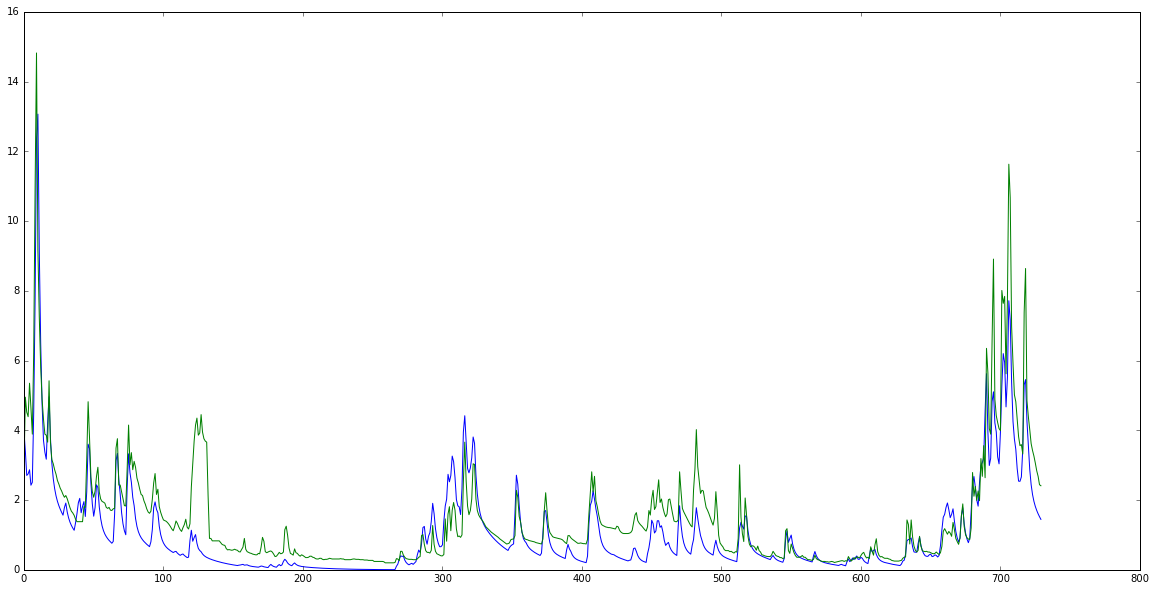

In [128]:
Qsim = simhyd_simulation(data2, [28.2,   144.37,   0.143, 130.34,   0.581,   1.0, 
                                 0.0461,   0.9,   1.817, 0.01])

plt.figure(figsize=(20, 10))
plt.plot(range(len(Qsim)), Qsim, 
         range(len(data2.Qobs)), data2.Qobs)

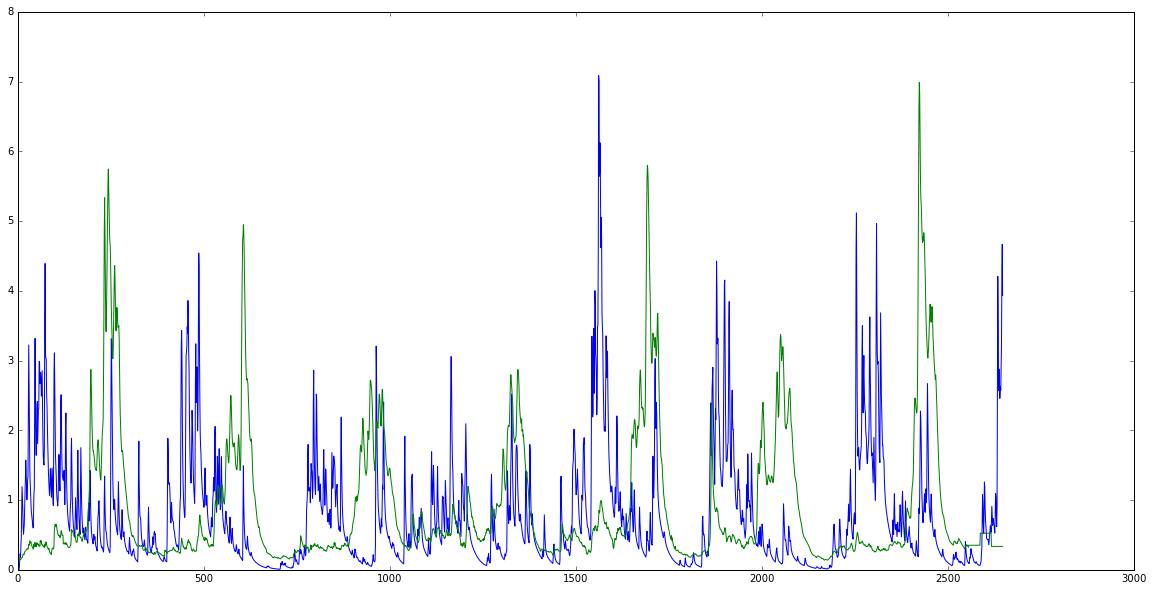

In [129]:
# love thing - check nadym basin without snow (snow routine) et al.

Qsim = simhyd_simulation(data, [28.2,   144.37,   0.143, 130.34,   0.581,   1.0, 
                                 0.0461,   0.9,   1.817, 0.01])

plt.figure(figsize=(20, 10))
plt.plot(range(len(Qsim)), Qsim, 
         range(len(data.Qobs)), data.Qobs)

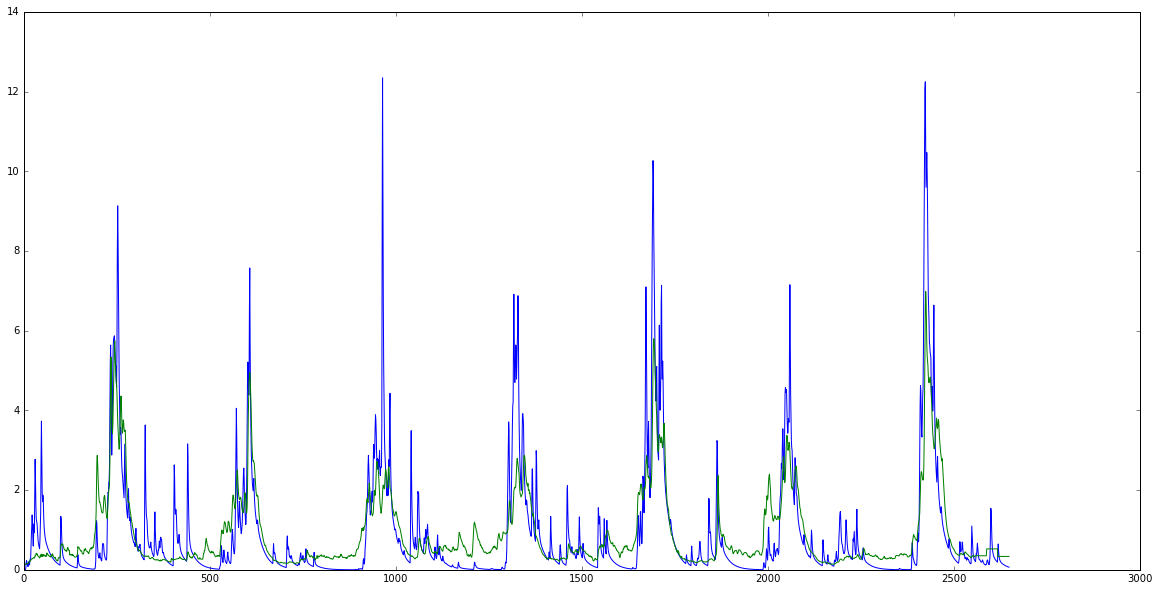

In [141]:
# now with snow routine

Qsim = simhyd_cemaneige(data, [28.2,   144.37,   0.143, 130.34,   0.581,   1.0, 
                                 0.0461,   0.9,   1.817, 0.01, 0.5, 3])

plt.figure(figsize=(20, 10))
plt.plot(range(len(Qsim)), Qsim, 
         range(len(data.Qobs)), data.Qobs)

In [135]:
def cemaneige_simulation(data, params):
    '''
    Cema-Neige snow model
    
    Input:
    1. Data - pandas dataframe with correspondent timeseries:
        'Temp'- mean daily temperature (Celsium degrees)
        'Prec'- mean daily precipitation (mm/day)
    2. Params - list of model parameters:
        'CTG' - dimensionless weighting coefficient of the snow pack thermal state
                [0, 1]
        'Kf'  - day-degree rate of melting (mm/(day*celsium degree))
                [1, 10]
    Output:
    Total amount of liquid and melting precipitation daily timeseries 
    (for coupling with hydrological model)
    '''
    
    ### reading the data ###
    Temp = data['Temp']
    Prec = data['Prec']
    FraqSolidPrecip = np.where(Temp < -0.2, 1, 0)
    
    CTG, Kf = params
    
    ### initialization ###
    ## constants ##
    # melting temperature
    Tmelt = 0
    # Threshold for solid precip
    # function for Mean Annual Solid Precipitation
    def MeanAnnualSolidPrecip(data):
        annual_vals = [data.Prec.ix[data.Prec.index.year == i][data.Temp < -0.2].sum()\
                       for i in np.unique(data.index.year)]
        return np.mean(annual_vals)
    
    MASP = MeanAnnualSolidPrecip(data)
    Gthreshold = 0.9*MASP
    MinSpeed = 0.1
    
    ## model states ##
    G = 0
    eTG = 0
    PliqAndMelt = 0
    
    ### ouput of snow model
    PliqAndMelt = np.zeros(len(Temp))
    
    for t in range(len(Temp)):
        ### solid and liquid precipitation accounting
        # liquid precipitation
        Pliq = (1 - FraqSolidPrecip[t]) * Prec[t]
        # solid precipitation
        Psol = FraqSolidPrecip[t] * Prec[t]
        ### Snow pack volume before melt
        G = G + Psol
        ### Snow pack thermal state before melt
        eTG = CTG * eTG + (1 - CTG) * Temp[t]
        # control eTG
        if eTG > 0: eTG = 0
        ### potential melt
        if (int(eTG) == 0) & (Temp[t] > Tmelt):
            PotMelt = Kf * (Temp[t] - Tmelt)
            if PotMelt > G: PotMelt = G
        else:
            PotMelt = 0
        ### ratio of snow pack cover (Gratio)
        if G < Gthreshold:
            Gratio = G/Gthreshold
        else:
            Gratio = 1
        ### actual melt
        Melt = ((1 - MinSpeed) * Gratio + MinSpeed) * PotMelt
        ### snow pack volume update
        G = G - Melt
        ### Gratio update
        if G < Gthreshold:
            Gratio = G/Gthreshold
        else:
            Gratio = 1
        
        ### Water volume to pass to the hydrological model
        PliqAndMelt[t] = Pliq + Melt
    
    return PliqAndMelt

In [136]:
def simhyd_cemaneige(data, params):
    '''
    SIMHYD hydrological model (Chiew, 2009)
    coupled with Cema-Neige snow model
    
    Input:
    data - pandas dataframe with correspondent variables:
        'Temp' - daily temperature (Celsium degrees)
        'Prec' - daily precipitation (mm/day)
        'Evap' - potential evapotraspiration (mm/day)
    parameters:
        'INSC' - interception store capacity (mm)
            [0, 50]
        'COEFF'- maximum infiltration loss
            [0, 400]
        'SQ'   - infiltration loss exponent
            [0, 10]
        'SMSC' - soil moisture storage capacity
            [1, 1000]
        'SUB'  - constant of proportionality in interflow equation
            [0, 1]
        'CRAK' - constant of proportionality in groundwater recharge equation
            [0, 1]
        'K'    - baseflow linear recession parameter
            [0, 1]
        'etmul'- added parameter to convert maxT to PET
            [0.1, 3]
        ### Muskinghum routing parameters
        'DELAY'- runoff delay
            [0.1, 5]
        'X_m'  - transformation parameter
            [0.01, 0.5]
        ### Cema-Neige parameters
        X5 : dimensionless weighting coefficient of the snow pack thermal state
            [0, 1]
        X6 : day-degree rate of melting (mm/(day*celsium degree))
            [1, 10]
    '''
    ### read parameters ###
    INSC, COEFF, SQ, SMSC, SUB, CRAK, K, etmul, DELAY, X_m, X5, X6 = params
    
    ### read the data ###
    #Temp = data['Temp']
    #Prec = data['Prec']
    Evap = data['Evap'] * etmul
    Prec = cemaneige_simulation(data, [X5, X6])
    
    ### states and parameters initialization ###
    # total runoff
    U    = np.zeros(len(Prec))
    # interception store
    IMAX = np.zeros(len(Prec)) 
    # interception amount
    INT  = np.zeros(len(Prec)) 
    # interception runoff
    INR  = np.zeros(len(Prec)) 
    # infiltration capacity
    RMO  = np.zeros(len(Prec)) 
    # direct runoff
    IRUN = np.zeros(len(Prec)) 
    # Soil evaporation
    ET   = np.zeros(len(Prec)) 
    # Saturation excess runoff and interflow
    SRUN = np.zeros(len(Prec)) 
    # Recharge
    REC  = np.zeros(len(Prec)) 
    # Infiltration into soil store
    SMF  = np.zeros(len(Prec)) 
    # potential evapotranspiration (PET - interception)
    POT  = np.zeros(len(Prec)) 
    # baseflow
    BAS  = np.zeros(len(Prec)) 
    # soil moisture storage
    SMS  = np.zeros(len(Prec)) 
    # ground water storage
    GW   = np.zeros(len(Prec))
    
    GWt1, GWt0 = 0, 0
    SMSt0 = 0.5
    SMSt1 = SMSt0 * SMSC
    
    for t in range(len(Prec)):
        # calculate interception store
        IMAX[t] = min(INSC, Evap[t])
        # then calculate interception
        INT[t] = min(IMAX[t], Prec[t])
        # calculate runoff after interception
        INR[t] = Prec[t] - INT[t]
        # calculate infiltration capacity
        RMO[t] = min(COEFF*np.exp(-SQ*SMSt1/SMSC), INR[t])
        # calculate direct runoff after loading to infiltration capacity
        IRUN[t] = INR[t] - RMO[t]
        # saturation excess runoff and interflow
        SRUN[t] = SUB * SMSt1 / SMSC * RMO[t]
        # calculate recharge
        REC[t] = CRAK * SMSt1 / SMSC * (RMO[t] - SRUN[t])
        # calculate infiltration into soil store
        SMF[t] = RMO[t] - SRUN[t] - REC[t]
        # calculate potential ET (amount of Evap after loses)
        POT[t] = Evap[t] - INT[t]
        # calculate soil evaporation
        ET[t] = min(10 * SMSt1/SMSC, POT[t])
        # calculate soil moisture storage (SMS) overflow
        SMS[t] = SMSt1 + SMF[t] - ET[t]
        # update states of SMS, REC and SMSt1
        if SMS[t] > SMSC:
            SMS[t] = SMSC
            REC[t] = REC[t] + SMS[t] - SMSC
        SMSt1 = SMS[t]
        # calculate baseflow
        BAS[t] = K * GWt1
        # calculate ground water storage
        GW[t] = GWt1 + REC[t] - BAS[t]
        # update state of GWt1
        GWt1 = GW[t]
        # final runoff (effective precipitation) calculation
        U[t] = IRUN[t] + SRUN[t] + BAS[t]
    
    ### Muskinghum routing scheme ###
    # initialize transformed runoff
    Q = np.zeros(len(U))
    # calculate Muskinghum components
    if (2*DELAY*X_m < 1) & (2*DELAY*(1-X_m) > 1):
        C0 = (-DELAY*X_m+0.5)/(DELAY*(1-X_m)+0.5)
        C1 = (DELAY*X_m+0.5)/(DELAY*(1-X_m)+0.5)
        C2 = (DELAY*(1-X_m)-0.5)/(DELAY*(1-X_m)+0.5)
    else:
        C0 = 0
        C1 = 1
        C2 = 0
    # check formal relations
    if (C0 + C1 + C2) != 1.0:
        C0 = 0
        C1 = 1
        C2 = 0
    # start transformation
    Q[0] = U[0]
    for t in range(len(U)-1):
        Q[t+1] = C0 * U[t+1] + C1 * U[t] + C2 * Q[t]
        # control Q
        if Q[t+1] < 0: Q[t+1] = 0
    
    return Q

Optimization routine

In [123]:
Qobs = data2.Qobs
Qm = Qobs.mean()

def simhyd_calibr(params):
    Qsim = simhyd_simulation(data2, params)
    return ((Qobs-Qsim)**2).sum()/((Qobs-Qm)**2).sum()

init_params = [2.5, 250, -0.4, 1.6, 0.6, 0.055, 0.040, 1, 1]

# init parameters bounds
bounds = ((0, 50), 
          (0, 400), 
          (0, 10), 
          (1, 1000), 
          (0, 1),
          (0, 1),
          (0, 1),
          (0.9, 1.1), 
          (0.1, 5), 
          (0.01, 0.5)
         )
init_param = [50, 100, 3, 100, 0, 1, 0.06, 1, 1, 0.1]

from scipy.optimize import differential_evolution

opt = differential_evolution(simhyd_calibr, bounds, maxiter=5, disp=True)

opt_param = opt.x

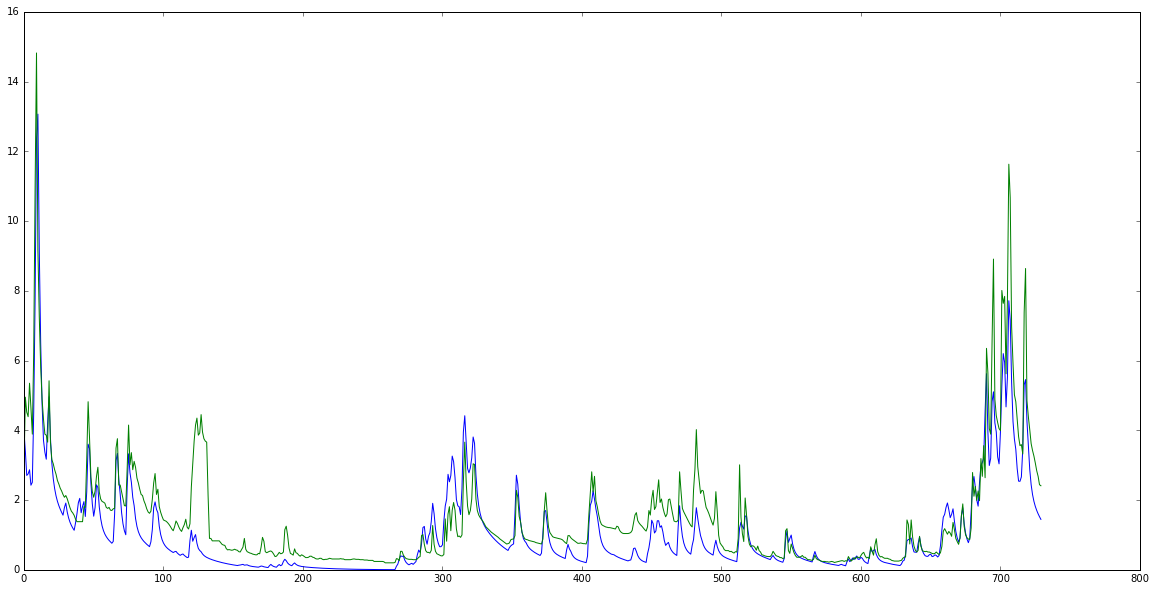

In [127]:
Qsim = simhyd_simulation(data2, [28.2,   144.37,   0.143, 130.34,   0.581,   1.0, 
                                 0.0461,   0.9,   1.817, 0.01])

plt.figure(figsize=(20, 10))
plt.plot(range(len(Qsim)), Qsim, 
         range(len(data2.Qobs)), data2.Qobs)

In [147]:
Qobs = data.Qobs
Qm = Qobs.mean()

def simhyd_cemaneige_calibr(params):
    Qsim = simhyd_cemaneige(data, params)
    return ((Qobs-Qsim)**2).sum()/((Qobs-Qm)**2).sum()

# init parameters bounds
bounds = ((0, 50), 
          (0, 400), 
          (0, 10), 
          (1, 1000), 
          (0, 1),
          (0, 1),
          (0, 1),
          (0.9, 1.1), 
          (0.1, 5), 
          (0.01, 0.5),
          (0, 1),
          (1, 10)
         )

from scipy.optimize import differential_evolution

opt = differential_evolution(simhyd_cemaneige_calibr, bounds, maxiter=5, disp=True)

opt_param = opt.x

differential_evolution step 1: f(x)= 0.339343
differential_evolution step 2: f(x)= 0.246807
differential_evolution step 3: f(x)= 0.246807
differential_evolution step 4: f(x)= 0.246807
differential_evolution step 5: f(x)= 0.232579


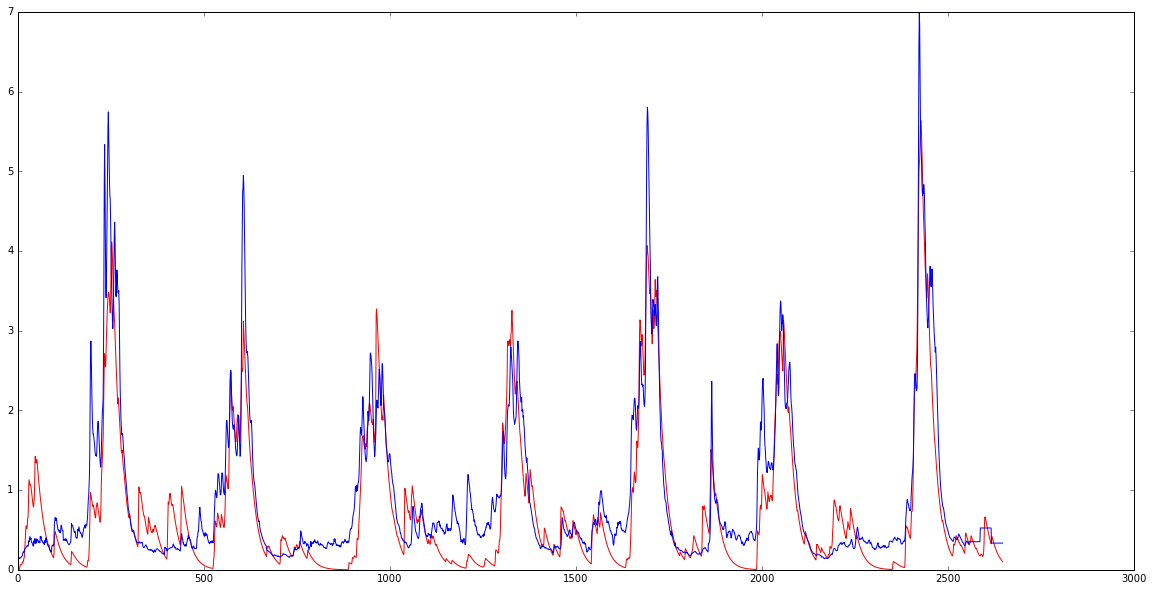

In [151]:
Qsim = simhyd_cemaneige(data, opt_param)

plt.figure(figsize=(20, 10))
plt.plot(range(len(Qsim)), Qsim, 'r', 
         range(len(Qobs)), Qobs, 'b')

In [152]:
opt_param

array([  2.44876740e+00,   2.77443664e+02,   2.46920325e+00,
         4.56530231e+02,   2.59636765e-01,   1.00000000e+00,
         4.91890001e-02,   9.00000000e-01,   5.00000000e+00,
         3.41278491e-02,   1.65478875e-01,   3.80091083e+00])

In [144]:
import sys
sys.path.append('../models/')

from ipywidgets import interact
from simhyd import interaction
%matplotlib inline

river_name = 'Pur River'
path_to_scheme = '../data/pur_scheme.csv'
path_to_observations = '../data/pur_observations.csv'

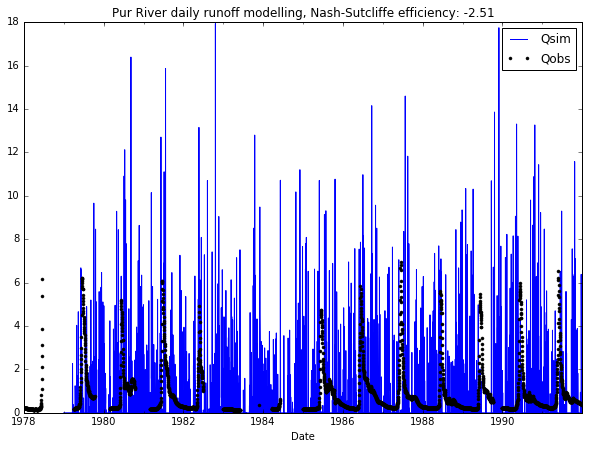

In [146]:
# interact with new PE module
interact(interaction, 
         river_name=river_name, 
         path_to_scheme=path_to_scheme, 
         path_to_observations=path_to_observations,
         INSC=(0,50,5), COEFF=(0,400,10), SQ=(0,10,1), SMSC=(1,1000,50), SUB=(0,1,0.1), 
         CRAK=(0,1,0.1), K=(0,1,0.1), etmul=(0.9,1.1,0.1), DELAY=(0.1,5,0.1), X_m=(0.01, 0.5, 0.01),
         __manual=True)

In [1]:
'abc' == 'abc'

True

In [2]:
'abc' is 'abc'

True